# COVID-19 Detection using Chest X-Ray Scans

In [1]:
!pip install -U imbalanced-learn

In [2]:
# Import necessary libraries

import numpy as np
import pandas as pd
import shutil
import os
import time
import cv2 as cv2
import tensorflow as tf
import seaborn as sns
import joblib
import matplotlib.pyplot as plt

from matplotlib.pyplot import imshow
from PIL import Image
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.models import Model, load_model, Sequential, save_model
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import SMOTE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from IPython.core.display import display, HTML
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

sns.set_style('darkgrid')

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

### COMBINING MULTIPLE DATASETS

In [3]:
# Load the COVID-19 Radiography Dataset

dataset_dir = '/kaggle/input/covid19-radiography-dataset/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset'

img_path = []
labels = []
class_list = os.listdir(dataset_dir)

for classes in class_list:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            labels.append(classes)  
            
img_series = pd.Series(img_path, name = 'img_path')
label_series = pd.Series(labels, name = 'labels')    
dataset_df = pd.concat([img_series, label_series], axis = 1)

# Drop Lung_Opacity class as there are some inconsistencies in it

dataset_df = dataset_df[dataset_df['labels'] != 'Lung_Opacity']
dataset_df.reset_index(drop = True, inplace = True)

print(dataset_df['labels'].value_counts())

Normal             10192
COVID               3616
Viral Pneumonia     1345
Name: labels, dtype: int64


In [4]:
# Load the Curated X-Ray Dataset

dataset_dir = '/kaggle/input/curated-chest-xray-image-dataset-for-covid19/Curated X-Ray Dataset'

img_path = []
labels = []

for classes in ["COVID-19", "Pneumonia-Viral"]:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            if classes == "COVID-19":
                labels.append("COVID")
            elif classes == "Pneumonia-Viral":
                labels.append("Viral Pneumonia")  
            
new_df = pd.DataFrame({'img_path': img_path, 'labels': labels})  
dataset_df = pd.concat([dataset_df, new_df], ignore_index = True)

print(dataset_df['labels'].value_counts())

Normal             10192
COVID               4897
Viral Pneumonia     3001
Name: labels, dtype: int64


In [5]:
# Load the Pneumonia COVID-19 Image Dataset

dataset_dir = '/kaggle/input/pneumonia-covid19-image-dataset'

img_path = []
labels = []

for classes in ["covid-19", "viral_pneumonia"]:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            if classes == "covid-19":
                labels.append("COVID")
            elif classes == "viral_pneumonia":
                labels.append("Viral Pneumonia")  
            
new_df = pd.DataFrame({'img_path': img_path, 'labels': labels})  
dataset_df = pd.concat([dataset_df, new_df], ignore_index = True)   

print(dataset_df['labels'].value_counts())

Normal             10192
COVID               5877
Viral Pneumonia     4513
Name: labels, dtype: int64


In [6]:
# Load the COVID-19, Pneumonia Normal Chest X-Ray PA Dataset

dataset_dir = '/kaggle/input/covid19-pneumonia-normal-chest-xray-pa-dataset'

img_path = []
labels = []

for classes in ["covid", "pneumonia"]:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            if classes == "covid":
                labels.append("COVID")
            elif classes == "pneumonia":
                labels.append("Viral Pneumonia")  
            
new_df = pd.DataFrame({'img_path': img_path, 'labels': labels})  
dataset_df = pd.concat([dataset_df, new_df], ignore_index = True)   

print(dataset_df['labels'].value_counts())

Normal             10192
COVID               8190
Viral Pneumonia     6826
Name: labels, dtype: int64


In [7]:
# Load the Chest X-ray COVID-19 and Pneumonia Dataset

dataset_dir = '/kaggle/input/chest-xray-covid19-pneumonia/Data/train'

img_path = []
labels = []

for classes in ["COVID19", "PNEUMONIA"]:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            if classes == "COVID19":
                labels.append("COVID")
            elif classes == "PNEUMONIA":
                labels.append("Viral Pneumonia")  
            
new_df = pd.DataFrame({'img_path': img_path, 'labels': labels})  
dataset_df = pd.concat([dataset_df, new_df], ignore_index = True)   

print(dataset_df['labels'].value_counts())

Viral Pneumonia    10244
Normal             10192
COVID               8650
Name: labels, dtype: int64


In [8]:
# Load the COVID-19, Pneumonia and Normal Chest X-ray Images Dataset

dataset_dir = '/kaggle/input/covid-pneumonia-normal-chest-xray-images'

img_path = []
labels = []

for classes in ["COVID"]:
    class_path = os.path.join(dataset_dir, classes)
    if os.path.isdir(class_path):
        file_list = os.listdir(class_path)
        for f in file_list:
            file_path = os.path.join(class_path,f)
            img_path.append(file_path)
            if classes == "COVID":
                labels.append(classes)
            
new_df = pd.DataFrame({'img_path': img_path, 'labels': labels})  
dataset_df = pd.concat([dataset_df, new_df], ignore_index = True)   

print(dataset_df['labels'].value_counts())

COVID              10276
Viral Pneumonia    10244
Normal             10192
Name: labels, dtype: int64


### DATA PRE-PROCESSING

In [9]:
# Split the dataset

train_split = 0.9
test_split = 0.05
dummy_split = test_split / (1-train_split)

train_df, dummy_df = train_test_split(dataset_df, train_size = train_split, shuffle = True, random_state = 123)
test_df, valid_df = train_test_split(dummy_df, train_size = dummy_split, shuffle = True, random_state = 123)

print ('Length of train_df : ', len(train_df), '\nLength of test_df : ', len(test_df), '\nLength of valid_df : ', len(valid_df))

Length of train_df :  27640 
Length of test_df :  1536 
Length of valid_df :  1536


In [10]:
# Create data generators for training, testing and validation

def rescale_images(img):
    return img / 127.5 - 1  # Scale the pixels to [-1, +1]

height = 128
width = 128
channels = 3
batch_size = 40

img_shape = (height, width, channels)
img_size = (height, width)
length = len(test_df)

test_batch_size = sorted([int(length / n) for n in range(1, length + 1) if length % n == 0 and length / n <= 80], reverse = True)[0]  
test_steps = int(length / test_batch_size)

data_generator = ImageDataGenerator(preprocessing_function = rescale_images)

train_gen = data_generator.flow_from_dataframe(train_df, x_col = 'img_path', y_col='labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle = True, batch_size = batch_size)

test_gen = data_generator.flow_from_dataframe(test_df, x_col = 'img_path', y_col='labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle = False, batch_size = test_batch_size)

valid_gen = data_generator.flow_from_dataframe(valid_df, x_col='img_path', y_col='labels', target_size = img_size, class_mode = 'categorical',
                                    color_mode='rgb', shuffle = True, batch_size = batch_size)

train_steps = int(len(train_gen.labels) / batch_size)

Found 27610 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 30 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


Found 1534 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 2 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


Found 1531 validated image filenames belonging to 3 classes.


/opt/conda/lib/python3.10/site-packages/keras/preprocessing/image.py:1137: UserWarning: Found 5 invalid image filename(s) in x_col="img_path". These filename(s) will be ignored.
  warnings.warn(


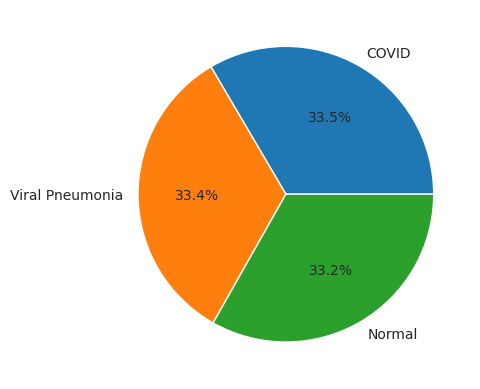

In [11]:
# Visualize data distribution across classes

class_len = dataset_df['labels'].value_counts().to_dict()

fig, ax = plt.subplots()
ax.pie(
    class_len.values(),
    labels=class_len.keys(),
    autopct="%1.1f%%"
)
plt.show()

In [12]:
# Balance the dataset by assigning appropriate class weights

class_weight = {}
train_dict = train_gen.class_indices
classes = list(train_dict.keys())
class_count = len(classes)
labels = train_gen.labels
count_array = np.zeros((class_count))

for label in labels:
    for value in train_dict.values():
        if label == value:
            count_array[value] += 1    

max_samples = np.max(count_array)
tab_represent = '{0:^30s}{1:^10s}{2:^9s}'.format('Class Name', 'Sample', 'Weights')
print(tab_represent)
for i in range (class_count):
    class_weight[i] = max_samples / count_array[i]
    tab_represent = f'{classes[i]:^30s}{str(count_array[i]):^10s}{class_weight[i]:^9.5f}'
    print (tab_represent)

          Class Name            Sample   Weights 
            COVID               9196.0   1.00185 
            Normal              9213.0   1.00000 
       Viral Pneumonia          9201.0   1.00130 


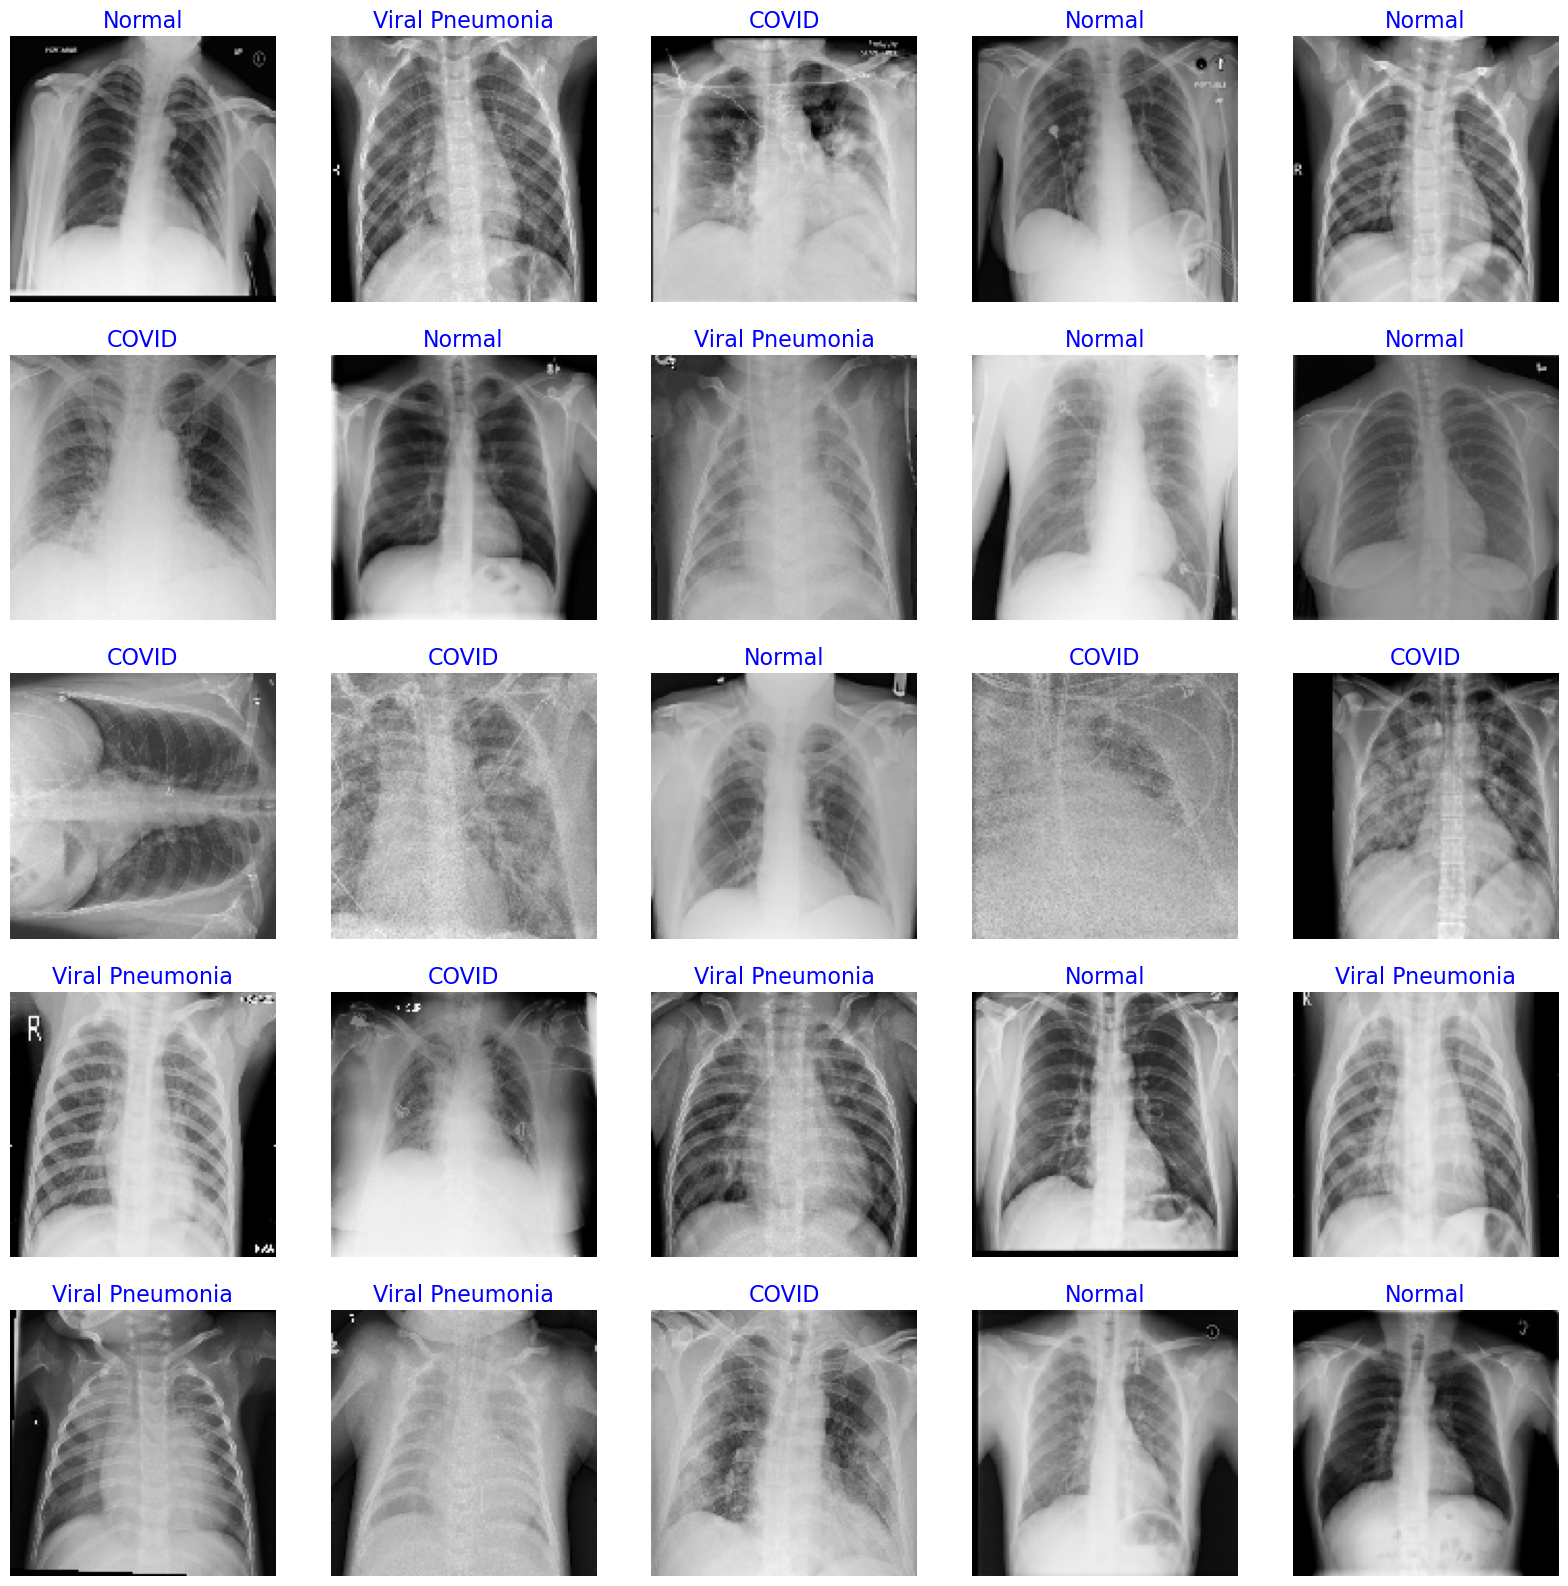

In [13]:
# View the dataset X-Ray scans with their labels

test_dict = test_gen.class_indices
classes = list(test_dict.keys())    
images, labels = next(train_gen) 

plt.figure(figsize = (20, 20))
length = len(labels)

if length < 10:   
    r = length
else:
    r = 25
    
for i in range(r):
    plt.subplot(5, 5, i + 1)
    image = (images[i] + 1) / 2 # Rescale images to [0, 1]
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name, color = 'blue', fontsize = 16)
    plt.axis('off')
    
plt.show()

### MODEL BUILDING
We need to define a class and few functions before building the model.

In [14]:
# Displays the text in the specified foreground and background specified colors

def print_in_color(txt_msg,fore_tupple,back_tupple,):    
    rf,gf,bf = fore_tupple
    rb,gb,bb = back_tupple
    
    msg = '{0}' + txt_msg
    mat = '\33[38;2;' + str(rf) +';' + str(gf) + ';' + str(bf) + ';48;2;' + str(rb) + ';' +str(gb) + ';' + str(bb) +'m' 
    
    print(msg .format(mat), flush = True)
    print('\33[0m', flush = True) 
    return

In [15]:
# Define subclass of callbacks to control learning rate

class LRA(keras.callbacks.Callback):
    reset = False
    count = 0
    stop_count = 0
    tepochs = 0
    
    def __init__(self,model, patience,stop_patience, threshold, factor, dwell, model_name, freeze,batches, initial_epoch):
        super(LRA, self).__init__()
        self.model = model
        self.patience = patience 
        self.stop_patience = stop_patience
        self.threshold = threshold 
        self.factor = factor
        self.dwell = dwell
        self.lr = float(tf.keras.backend.get_value(model.optimizer.lr))
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf
        self.initial_epoch = initial_epoch 
        self.batches = batches
        
        best_weights = self.model.get_weights() 
        msg = ' '
        
        if freeze==True:
            msgs = f' Start training on base model - {model_name} with weights frozen to imagenet weights. Initializing LRA callback'
        else:
            msgs = f' Start training on base model - {model_name}. Training all the layers '
            
        print_in_color (msgs, (244, 252, 3), (55,65,80))
        
        
    def on_train_begin(self, logs=None):
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy',                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration', 'Batch')
        print_in_color(msg, (244, 252, 3), (55, 65, 80)) 
        
    def on_train_batch_begin(self, batch, logs = None):
        msg='{0:83s}{1:4s}of {2:5s}'.format(' ', str(batch), str(self.batches))
        print(msg, '\r', end = '') 
                
    def on_epoch_begin(self,epoch, logs = None):
        self.now = time.time()
        
    def on_epoch_end(self, epoch, logs = None):  
        later = time.time()
        duration = later-self.now 
        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr = lr
        v_loss = logs.get('val_loss')
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        
        if acc < self.threshold:
            monitor = 'accuracy'
            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                LRA.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                color= (0,255,0)
                self.lr = lr
                
            else:                 
                if self.count>=self.patience -1:
                    color = (245, 170, 66)
                    self.lr = lr * self.factor 
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    self.count = 0 
                    self.stop_count=self.stop_count + 1
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)
                    else:
                        if v_loss < self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count = self.count + 1
                    
        else: 
            monitor='val_loss'
            if v_loss <  self.lowest_vloss:
                self.lowest_vloss = v_loss
                LRA.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0  
                color = (0,255,0)
                self.lr = lr
                
            else:
                if self.count>=self.patience-1:
                    color = (245, 170, 66)
                    self.lr = self.lr * self.factor
                    self.stop_count = self.stop_count + 1
                    self.count = 0
                    tf.keras.backend.set_value(self.model.optimizer.lr, self.lr)
                    if self.dwell:
                        self.model.set_weights(LRA.best_weights)
                else: 
                    self.count = self.count + 1
                if acc > self.highest_tracc:
                    self.highest_tracc =  acc
                    
        msg = f'{str(epoch + 1):^3s}/{str(LRA.tepochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{self.lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print_in_color (msg,color, (55, 65, 80))
        if self.stop_count > self.stop_patience - 1:
            msg = f' Training halted at epoch {epoch + 1}, after {self.stop_patience} adjustments of learning rate with no improvement.'
            print_in_color(msg, (0, 255, 0), (55, 65, 80))
            self.model.stop_training = True

In [16]:
# Define data plots

def tr_plot(tr_data, start_epoch):    
    tacc = tr_data.history['accuracy']
    tloss = tr_data.history['loss']
    vacc = tr_data.history['val_accuracy']
    vloss = tr_data.history['val_loss']
    Epoch_count = len(tacc) + start_epoch
    Epochs = []
    
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i + 1)   
        
    index_loss = np.argmin(vloss)
    val_lowest = vloss[index_loss]
    index_acc = np.argmax(vacc)
    acc_highest = vacc[index_acc]
    
    plt.style.use('fivethirtyeight')
    sc_label = 'Best Epoch = ' + str(index_loss + 1 + start_epoch)
    vc_label = 'Best Epoch = ' + str(index_acc + 1 + start_epoch)
    
    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20,8))
    axes[0].plot(Epochs,tloss, 'r', label = 'Training Loss')
    axes[0].plot(Epochs,vloss, 'g', label = 'Validation Loss' )
    axes[0].scatter(index_loss + 1 + start_epoch, val_lowest, s = 150, c = 'blue', label = sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc, 'r', label = 'Training Accuracy')
    axes[1].plot (Epochs,vacc, 'g', label = 'Validation Accuracy')
    axes[1].scatter(index_acc +1 + start_epoch,acc_highest, s = 150, c = 'blue', label = vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    
    plt.tight_layout    
    plt.show()

In [17]:
# Generate Confusion Matrix and Classification Report

def print_info( test_gen, preds, print_code, save_dir, subject ):
    class_dict = test_gen.class_indices
    labels =  test_gen.labels
    file_names =  test_gen.filenames 
    
    error_list = []
    true_class = []
    pred_class = []
    prob_list = []
    new_dict = {}
    error_indices = []
    y_pred = []
    
    for key,value in class_dict.items():
        new_dict[value] = key             
    
    classes = list(new_dict.values())     
    dict_as_text = str(new_dict)
    dict_name = subject + '-' +str(len(classes)) + '.txt'  
    dict_path = os.path.join(save_dir, dict_name)   
    
    with open(dict_path, 'w') as x_file:
        x_file.write(dict_as_text)    
        
    errors = 0      
    
    for i, p in enumerate(preds):
        pred_index = np.argmax(p)        
        true_index = labels[i]  
        if pred_index != true_index: 
            error_list.append(file_names[i])
            true_class.append(new_dict[true_index])
            pred_class.append(new_dict[pred_index])
            prob_list.append(p[pred_index])
            error_indices.append(true_index)            
            errors = errors + 1
        y_pred.append(pred_index)   
        
    if print_code != 0:
        if errors > 0:
            if print_code > errors:
                r = errors
            else:
                r = print_code           
            
            msg = '{0:^28s}{1:^28s}{2:^28s}{3:^16s}'.format('Filename', 'Predicted Class' , 'True Class', 'Probability')
            print_in_color(msg, (0, 255, 0),(55, 65, 80))
            
            for i in range(r):                
                split_1 = os.path.split(error_list[i])                
                split_2 = os.path.split(split_1[0])                
                fname = split_2[1] + '/' + split_1[1]
                msg = '{0:^28s}{1:^28s}{2:^28s}{3:4s}{4:^6.4f}'.format(fname, pred_class[i], true_class[i], ' ', prob_list[i])
                print_in_color(msg, (255, 255, 255), (55, 65, 60))
                
        else:
            msg = 'With accuracy of 100 % there are no errors to print'
            print_in_color(msg, (0, 255, 0),(55, 65, 80))
            
    if errors > 0:
        plot_bar = []
        plot_class = []
        
        for  key, value in new_dict.items():        
            count = error_indices.count(key) 
            if count != 0:
                plot_bar.append(count) 
                plot_class.append(value)  
                
        fig = plt.figure()
        fig.set_figheight(len(plot_class)/3)
        fig.set_figwidth(10)
        plt.style.use('fivethirtyeight')
        
        for i in range(0, len(plot_class)):
            c = plot_class[i]
            x = plot_bar[i]
            plt.barh(c, x, )
            plt.title('Error distribution - Test Set')
    y_true = np.array(labels)        
    y_pred = np.array(y_pred)
    print("\n")
    
    if len(classes) <= 30:    
        cm = confusion_matrix(y_true, y_pred )        
        length = len(classes)
        if length < 8:
            fig_width = 8
            fig_height = 8
        else:
            fig_width = int(length * .5)
            fig_height = int(length * .5)
            
        plt.figure(figsize = (fig_width, fig_height))
        sns.heatmap(cm, annot = True, vmin = 0, fmt = 'g', cmap = 'Blues', cbar = False)       
        plt.xticks(np.arange(length) + .5, classes, rotation = 90)
        plt.yticks(np.arange(length) + .5, classes, rotation = 0)
        plt.xlabel("Prediction")
        plt.ylabel("Original")
        plt.title("Confusion Matrix")
        plt.show()
        
    clr = classification_report(y_true, y_pred, target_names = classes)
    print("\nClassification Report :\n-------------------------\n", clr)

#### TRANSFER LEARNING : InceptionResNetV2

In [18]:
# Build the InceptionResNetV2 model

model_name = 'InceptionResNetV2'
base_model = tf.keras.applications.InceptionResNetV2(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
model = Model(inputs = base_model.input, outputs = output)

219055592/219055592 [==============================] - 1s 0us/step


In [19]:
# Compile the model

model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - InceptionResNetV2. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /15     3.249   93.712   4.65176  97.779   0.00100  0.00100  val_loss   514.10 

 2 /15     0.573   97.798   2.78078  98.040   0.00100  0.00100  val_loss   195.84 

 3 /15     0.198   98.602   0.16440  98.498   0.00100  0.00100  val_loss   197.44 

 4 /15     0.147   98.841   0.15530  98.628   0.00100  0.00100  val_loss   197.98 

 5 /15     0.113   99.420   1.19077  92.750   0.00100  0.00050  val_loss   197.63 

 6 /15     0.104   99.685   0.10719  98.955   0.00050  0.00050  val_loss   198.21 

 7 /15     0.090   99.826   0.21602  99.151   0.00050  0.00025  val_loss   196.47 

 8 /15     0.088   99.877   0.12216  99.086   0.00025  0.00013  val_loss   198.91 

 9 /15     0.089   99.902   0.09571  99.282   0.00013  0.00013  val_loss   200.76 

10 /15     0.083   99.960   0.09405  99.151   0.00013  0.00013  val_loss   2

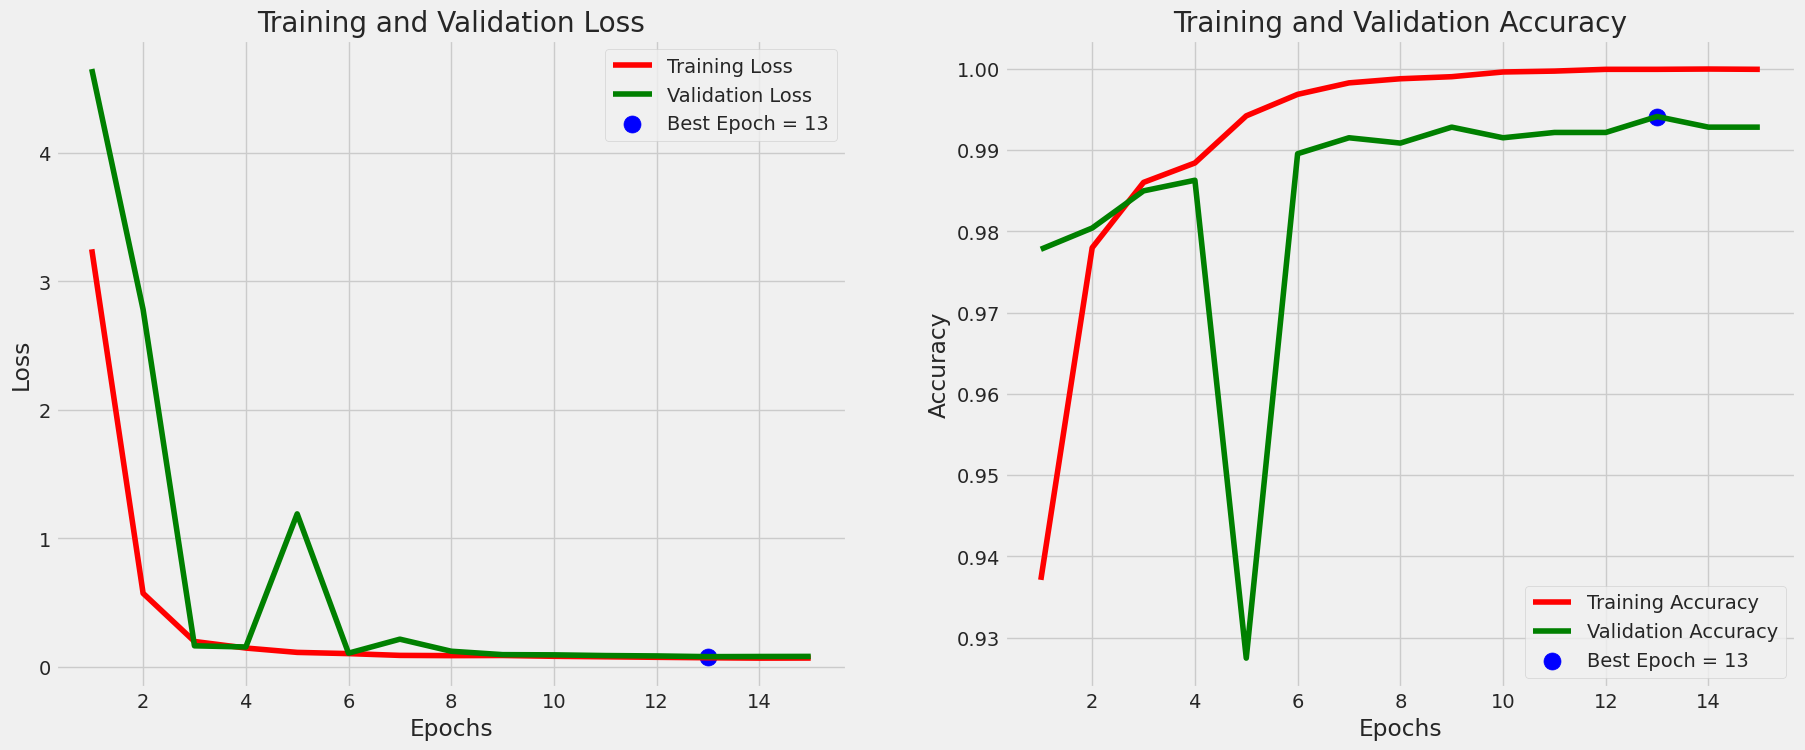

24/24 [==============================] - 24s 981ms/step - loss: 0.0899 - accuracy: 0.9896
Accuracy on the Test set : 98.96 %



In [20]:
# Evaluate the model

tr_plot(history, 0)
acc = model.evaluate(test_gen, batch_size = test_batch_size, verbose = 1, steps = test_steps, return_dict = False)[1] * 100
msg = f'Accuracy on the Test set : {acc:5.2f} %'
print_in_color(msg, (0,255,0),(55,65,80))

In [21]:
# Save the model

joblib.dump(model, 'joblib_xray_inception_model.h5')
model.save('xray_inception_model.h5')

24/24 [==============================] - 19s 664ms/step




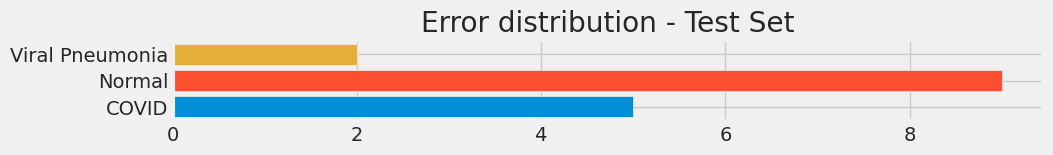

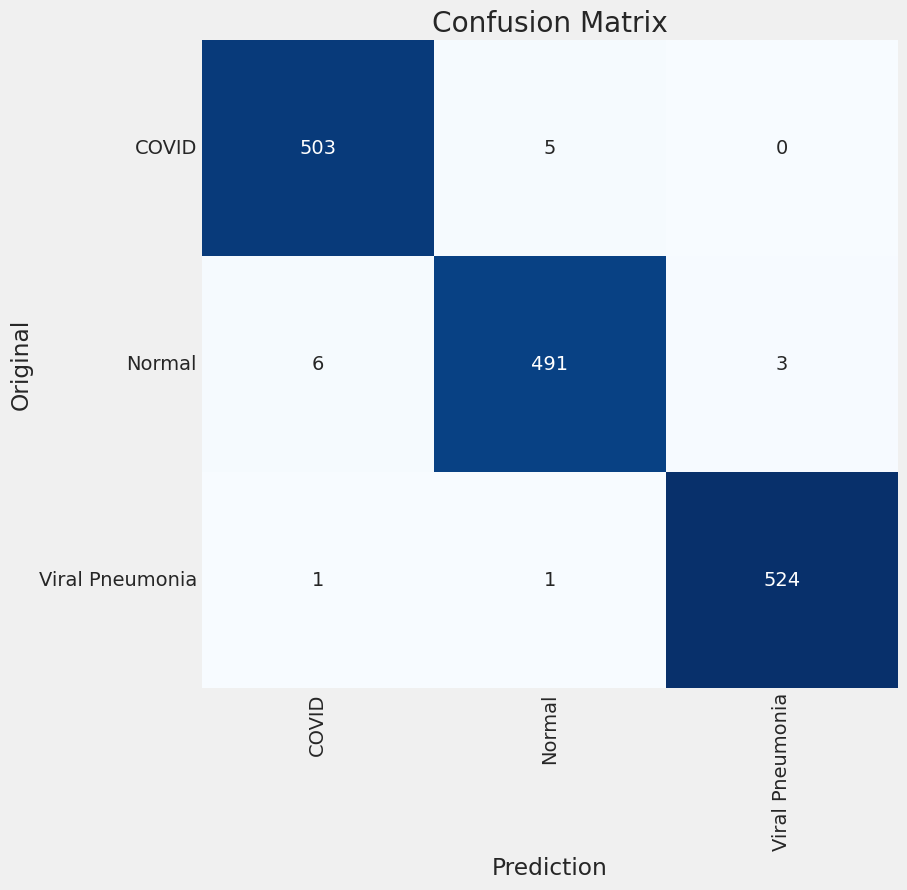


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       0.99      0.99      0.99       508
         Normal       0.99      0.98      0.98       500
Viral Pneumonia       0.99      1.00      1.00       526

       accuracy                           0.99      1534
      macro avg       0.99      0.99      0.99      1534
   weighted avg       0.99      0.99      0.99      1534



In [22]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_inception_model')  

#### TRANSFER LEARNING : ResNet50

In [23]:
# Build the ResNet50 model

model_name = 'ResNet50'
base_model = tf.keras.applications.resnet50.ResNet50(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
resnet_model = Model(inputs = base_model.input, outputs = output)

94765736/94765736 [==============================] - 0s 0us/step


In [24]:
# Compile the model

resnet_model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = resnet_model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - ResNet50. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /15     2.784   95.828   1.93012  60.810   0.00100  0.00100  val_loss   265.51 

 2 /15     0.377   98.421   0.24092  96.930   0.00100  0.00100  val_loss   186.75 

 3 /15     0.178   98.801   0.15840  98.171   0.00100  0.00100  val_loss   182.44 

 4 /15     0.141   98.997   0.11324  98.955   0.00100  0.00100  val_loss   186.22 

 5 /15     0.124   99.221   0.17258  96.277   0.00100  0.00050  val_loss   186.17 

 6 /15     0.102   99.663   0.10131  99.347   0.00050  0.00050  val_loss   185.27 

 7 /15     0.087   99.873   0.09466  99.216   0.00050  0.00050  val_loss   190.14 

 8 /15     0.084   99.794   0.09911  99.282   0.00050  0.00025  val_loss   185.45 

 9 /15     0.078   99.931   0.08795  99.282   0.00025  0.00025  val_loss   183.10 

10 /15     0.072   99.964   0.08438  99.347   0.00025  0.00025  val_loss   184.72 

1

In [25]:
# Save the model

joblib.dump(resnet_model, 'joblib_xray_resnet_model.h5')
resnet_model.save('xray_resnet_model.h5')

24/24 [==============================] - 12s 449ms/step




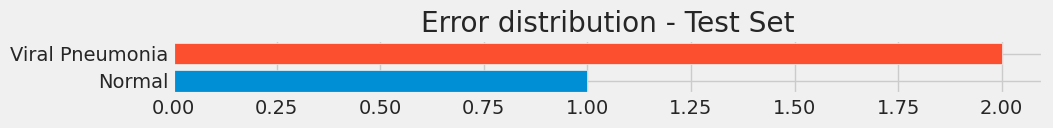

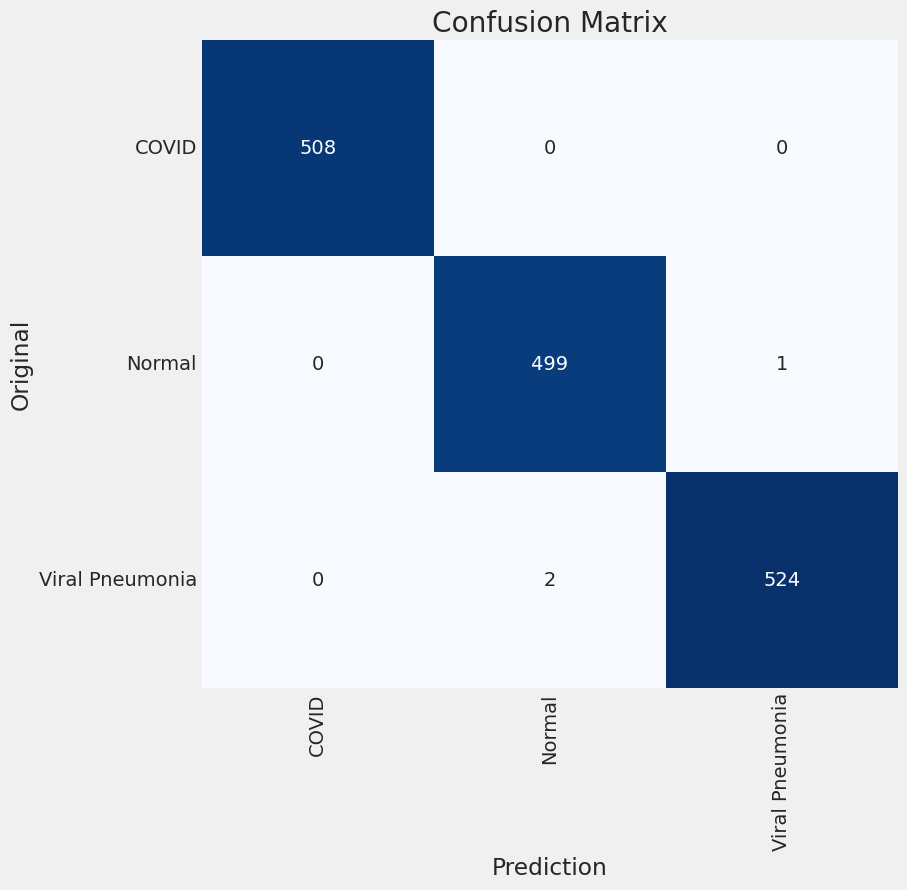


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       1.00      1.00      1.00       508
         Normal       1.00      1.00      1.00       500
Viral Pneumonia       1.00      1.00      1.00       526

       accuracy                           1.00      1534
      macro avg       1.00      1.00      1.00      1534
   weighted avg       1.00      1.00      1.00      1534



In [26]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = resnet_model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_resnet_model')  

#### TRANSFER LEARNING : DenseNet121

In [27]:
# Build the DenseNet121 model

model_name = 'DenseNet121'
base_model = tf.keras.applications.densenet.DenseNet121(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
densenet_model = Model(inputs = base_model.input, outputs = output)

29084464/29084464 [==============================] - 0s 0us/step


In [28]:
# Compile the model

densenet_model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = densenet_model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - DenseNet121. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /15     1.738   95.791   0.44660  97.322   0.00100  0.00100  val_loss   260.27 

 2 /15     0.274   98.218   0.17343  98.302   0.00100  0.00100  val_loss   187.75 

 3 /15     0.158   98.718   0.13549  98.367   0.00100  0.00100  val_loss   188.89 

 4 /15     0.128   98.866   0.16813  96.865   0.00100  0.00050  val_loss   188.04 

 5 /15     0.111   99.504   0.09927  99.412   0.00050  0.00050  val_loss   188.87 

 6 /15     0.090   99.786   0.09628  99.282   0.00050  0.00050  val_loss   190.09 

 7 /15     0.081   99.841   0.09392  99.020   0.00050  0.00050  val_loss   189.77 

 8 /15     0.072   99.873   0.08484  99.216   0.00050  0.00050  val_loss   189.87 

 9 /15     0.067   99.888   0.07672  99.282   0.00050  0.00050  val_loss   188.83 

10 /15     0.062   99.917   0.06921  99.282   0.00050  0.00050  val_loss   190.46 

In [29]:
# Save the model

joblib.dump(densenet_model, 'joblib_xray_densenet_model.h5')
densenet_model.save('xray_densenet_model.h5')

24/24 [==============================] - 15s 502ms/step




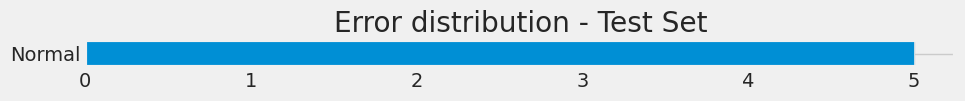

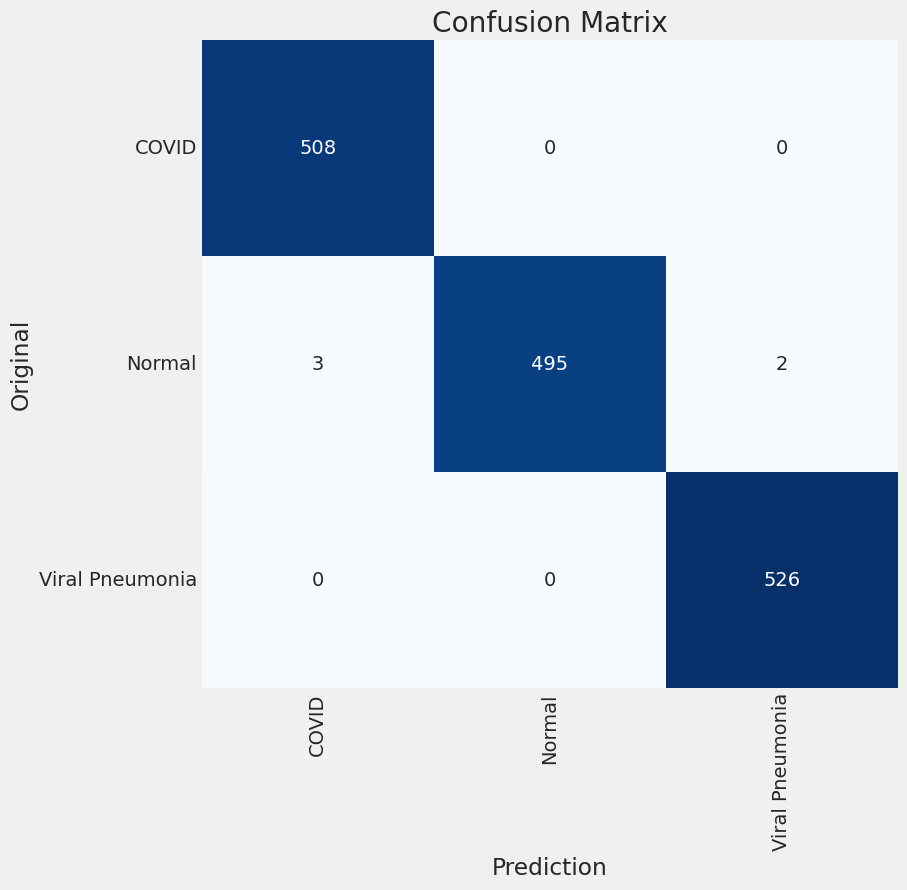


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       0.99      1.00      1.00       508
         Normal       1.00      0.99      0.99       500
Viral Pneumonia       1.00      1.00      1.00       526

       accuracy                           1.00      1534
      macro avg       1.00      1.00      1.00      1534
   weighted avg       1.00      1.00      1.00      1534



In [30]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = densenet_model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_densenet_model')  

#### TRANSFER LEARNING - VGG19

In [31]:
# Build the VGG19 model

model_name = 'VGG19'
base_model = tf.keras.applications.vgg19.VGG19(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
vgg19_model = Model(inputs = base_model.input, outputs = output)

80134624/80134624 [==============================] - 0s 0us/step


In [32]:
# Compile the model

vgg19_model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = vgg19_model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - VGG19. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /15     2.109   83.904   0.84045  87.329   0.00100  0.00100  accuracy   199.58 

 2 /15     0.499   93.003   0.53476  84.977   0.00100  0.00100  val_loss   187.25 

 3 /15     0.281   95.223   0.83544  77.858   0.00100  0.00050  val_loss   187.14 

 4 /15     0.269   96.038   0.77203  73.677   0.00050  0.00025  val_loss   187.82 

 5 /15     0.269   96.454   0.58950  79.882   0.00025  0.00013  val_loss   187.73 

 Training halted at epoch 5, after 3 adjustments of learning rate with no improvement.



In [33]:
# Save the model

joblib.dump(vgg19_model, 'joblib_xray_vgg19_model.h5')
vgg19_model.save('xray_vgg19_model.h5')

24/24 [==============================] - 13s 457ms/step




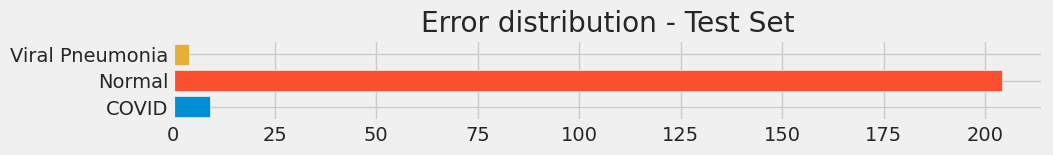

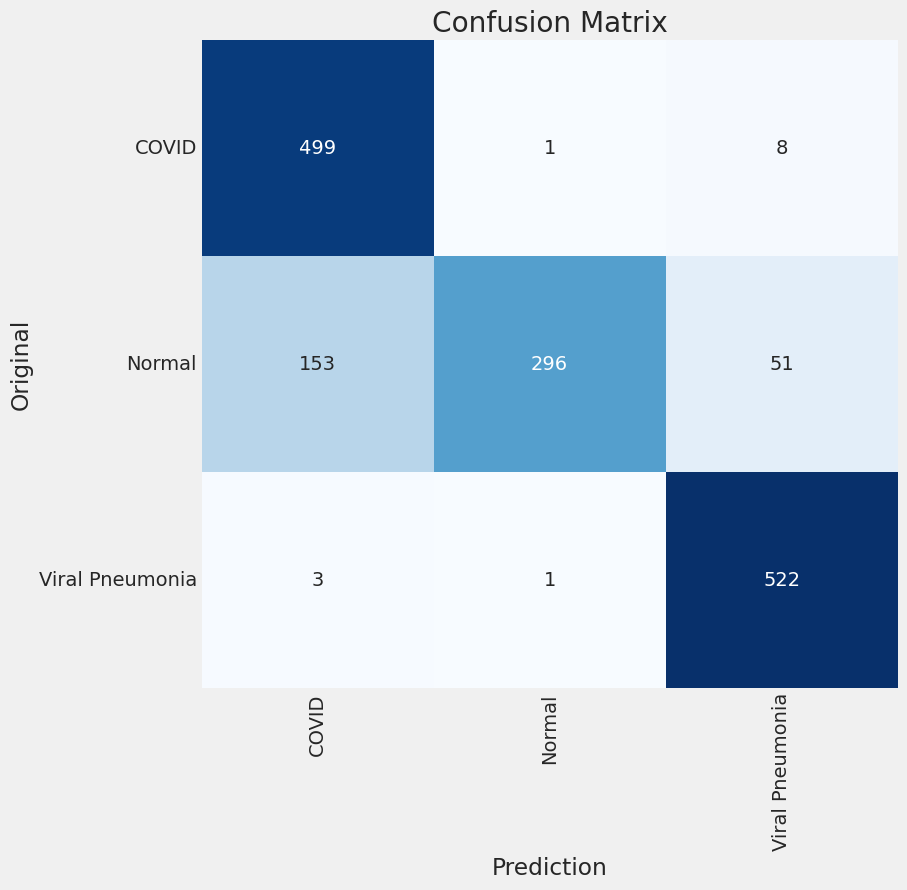


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       0.76      0.98      0.86       508
         Normal       0.99      0.59      0.74       500
Viral Pneumonia       0.90      0.99      0.94       526

       accuracy                           0.86      1534
      macro avg       0.88      0.86      0.85      1534
   weighted avg       0.88      0.86      0.85      1534



In [34]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = vgg19_model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_vgg19_model')  

#### TRANSFER LEARNING : EfficientNetV2B3

In [35]:
# Build the EfficientNetV2B3 model

model_name = 'EfficientNetV2B3'
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer = regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
efficientnet_model = Model(inputs = base_model.input, outputs = output)

52606240/52606240 [==============================] - 0s 0us/step


In [36]:
# Compile the model

efficientnet_model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = efficientnet_model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - EfficientNetV2B3. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  



2023-06-24 09:46:30.637760: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


 1 /15     3.101   90.663   1.12835  86.414   0.00100  0.00100  val_loss   265.26 

 2 /15     0.515   96.266   0.66602  84.455   0.00100  0.00100  val_loss   193.95 

 3 /15     0.244   97.345   0.43396  88.961   0.00100  0.00100  val_loss   191.96 

 4 /15     0.183   97.903   1.11996  67.276   0.00100  0.00050  val_loss   193.11 

 5 /15     0.161   98.736   0.29736  92.619   0.00050  0.00050  val_loss   190.00 

 6 /15     0.133   99.037   0.63184  78.903   0.00050  0.00025  val_loss   189.71 

 7 /15     0.128   99.247   0.20725  95.624   0.00025  0.00025  val_loss   192.35 

 8 /15     0.112   99.562   0.51206  84.324   0.00025  0.00013  val_loss   190.45 

 9 /15     0.113   99.486   0.15776  97.649   0.00013  0.00013  val_loss   190.60 

10 /15     0.106   99.591   0.11391  98.955   0.00013  0.00013  val_loss   192.88 

11 /15     0.100   99.689   0.11629  98.824   0.00013  0.00006  val_loss   193.23 

12 /15     0.101   99.692   0.10950  98.694   0.00006  0.00006  val_loss   1

In [37]:
# Save the model

joblib.dump(efficientnet_model, 'joblib_xray_efficientnet_model.h5')
efficientnet_model.save('xray_efficientnet_model.h5')

24/24 [==============================] - 13s 419ms/step




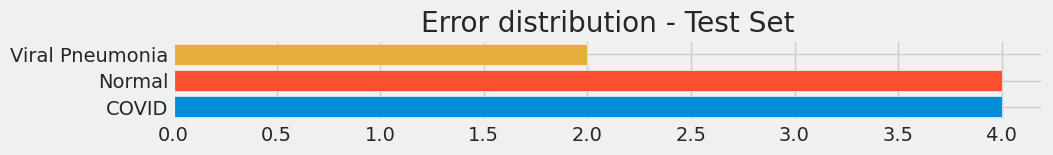

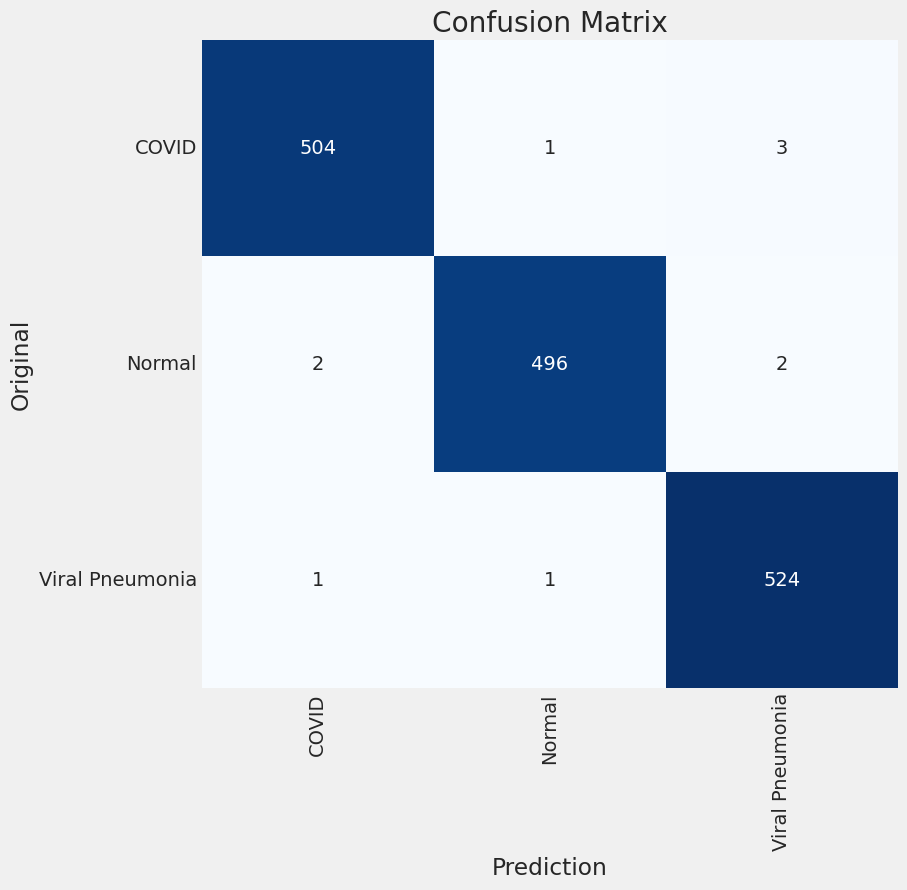


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       0.99      0.99      0.99       508
         Normal       1.00      0.99      0.99       500
Viral Pneumonia       0.99      1.00      0.99       526

       accuracy                           0.99      1534
      macro avg       0.99      0.99      0.99      1534
   weighted avg       0.99      0.99      0.99      1534



In [38]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = efficientnet_model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_efficientnet_model')  

#### TRANSFER LEARNING : MobileNetV2

In [39]:
# Build the MobileNetV2 model

model_name = 'MobileNetV2'
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(include_top = False, weights = "imagenet", input_shape = img_shape, pooling = 'max') 
x = base_model.output
x = keras.layers.BatchNormalization(axis = -1, momentum=0.99, epsilon = 0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer = regularizers.l1(0.006) ,activation = 'relu')(x)
x = Dropout(rate = .45, seed = 123)(x)        
output = Dense(class_count, activation = 'softmax')(x)
mobilenet_model = Model(inputs = base_model.input, outputs = output)

9406464/9406464 [==============================] - 0s 0us/step


In [40]:
# Compile the model

mobilenet_model.compile(Adamax(lr = .001), loss = 'categorical_crossentropy', metrics = ['accuracy']) 

# Train the model

epochs = 15
patience = 1 
stop_patience = 3 
threshold = .9 
factor = .5 
dwell = True 
freeze = False 
batches = train_steps
callbacks = [LRA(model = model,patience = patience,stop_patience = stop_patience, threshold = threshold,
                   factor = factor,dwell = dwell, model_name = model_name, freeze = freeze, batches = batches, initial_epoch = 0 )]
LRA.tepochs = epochs  
history = mobilenet_model.fit(x = train_gen,  epochs = epochs, verbose = 0, callbacks = callbacks,  validation_data = valid_gen,
               validation_steps = None,  shuffle = False,  initial_epoch = 0, class_weight = class_weight)

 Start training on base model - MobileNetV2. Training all the layers 

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  Duration Batch  

 1 /15     2.528   94.958   0.68680  94.840   0.00100  0.00100  val_loss   203.99 

 2 /15     0.332   98.019   0.35037  91.835   0.00100  0.00100  val_loss   179.58 

 3 /15     0.185   98.417   0.16860  97.714   0.00100  0.00100  val_loss   176.33 

 4 /15     0.149   98.689   1.18934  70.999   0.00100  0.00050  val_loss   176.35 

 5 /15     0.130   99.323   0.63777  82.038   0.00050  0.00025  val_loss   178.60 

 6 /15     0.125   99.489   0.16103  97.453   0.00025  0.00025  val_loss   176.03 

 7 /15     0.108   99.732   0.20168  96.016   0.00025  0.00013  val_loss   176.53 

 8 /15     0.107   99.804   0.19007  96.081   0.00013  0.00006  val_loss   178.13 

 9 /15     0.110   99.783   0.17402  96.538   0.00006  0.00003  val_loss   175.29 

 Training halted at epoch 9, after 3 adjustments of learning rate with no improvem

In [41]:
# Save the model

joblib.dump(mobilenet_model, 'joblib_xray_mobilenet_model.h5')
mobilenet_model.save('xray_mobilenet_model.h5')

24/24 [==============================] - 11s 420ms/step




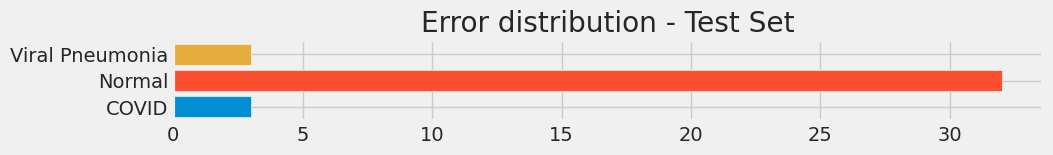

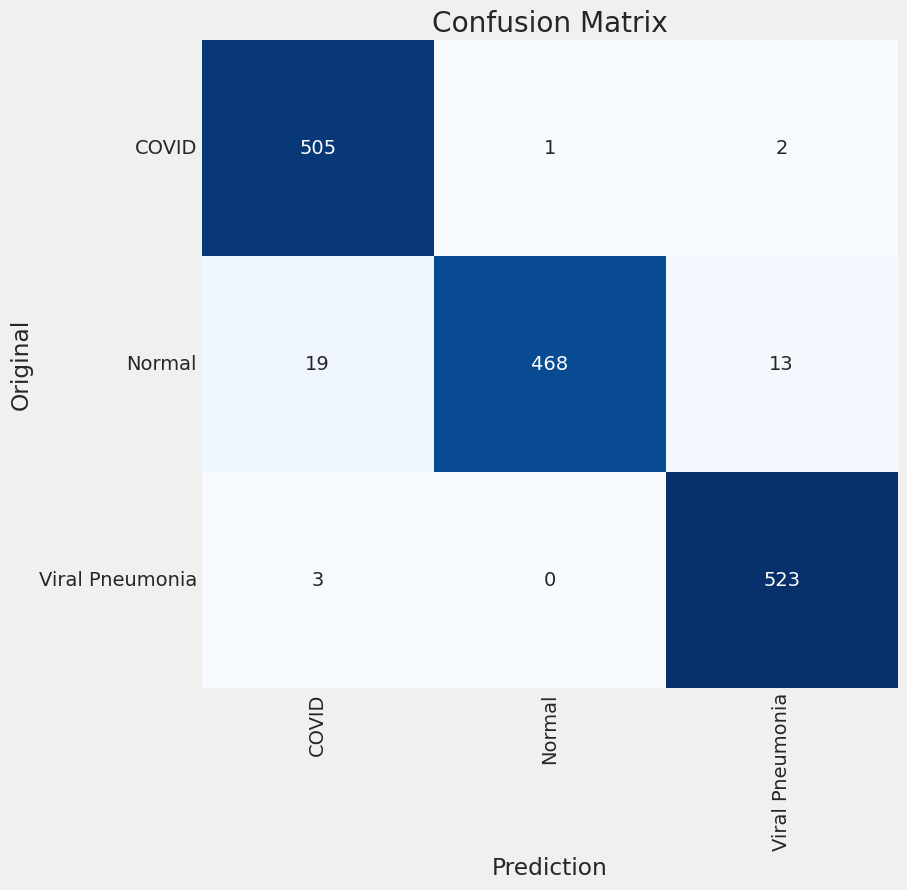


Classification Report :
-------------------------
                  precision    recall  f1-score   support

          COVID       0.96      0.99      0.98       508
         Normal       1.00      0.94      0.97       500
Viral Pneumonia       0.97      0.99      0.98       526

       accuracy                           0.98      1534
      macro avg       0.98      0.97      0.97      1534
   weighted avg       0.98      0.98      0.98      1534



In [42]:
# Plot the evaluation results

print_code = 0
save_dir = '/kaggle/working/'
preds = mobilenet_model.predict(test_gen) 
print_info(test_gen, preds, print_code, save_dir, 'xray_mobilenet_model')  

### ENSEMBLE MODELLING

In [43]:
# Ensemble Model's Estimators

estimators = [] 
estimators.append(('InceptionResnetV2', model)) 
estimators.append(('ResNet50', resnet_model)) 
estimators.append(('DenseNet121', densenet_model))
estimators.append(('VGG19', vgg19_model)) 
estimators.append(('EfficientNetV2B3', efficientnet_model))
estimators.append(('MobileNetV2', mobilenet_model))

In [44]:
# InceptionResNetV2 Model

test_gen.reset()
inception_pred = model.predict(
        test_gen,        
        verbose = 1)

testY = test_gen.classes

# ResNet50 Model

test_gen.reset()
resnet_pred = resnet_model.predict(
        test_gen,        
        verbose = 1)

# DenseNet121 Model

test_gen.reset()
densenet_pred = densenet_model.predict(
        test_gen,        
        verbose = 1)

# VGG19 Model

test_gen.reset()
vgg19_pred = vgg19_model.predict(
        test_gen,        
        verbose = 1)

# EfficientNetV2B3 Model

test_gen.reset()
efficientnet_pred = efficientnet_model.predict(
        test_gen,        
        verbose = 1)

# MobileNetV2 Model

test_gen.reset()
mobilenet_pred = mobilenet_model.predict(
        test_gen, 
        verbose=1)

24/24 [==============================] - 9s 368ms/step


In [45]:
# Stack up all the models

stack = np.dstack((inception_pred, resnet_pred, densenet_pred, vgg19_pred, efficientnet_pred, mobilenet_pred))
avg_ensemble_prob = np.mean(stack,axis = -1)
avg_ensemble_pred = np.argmax(avg_ensemble_prob,axis = -1)

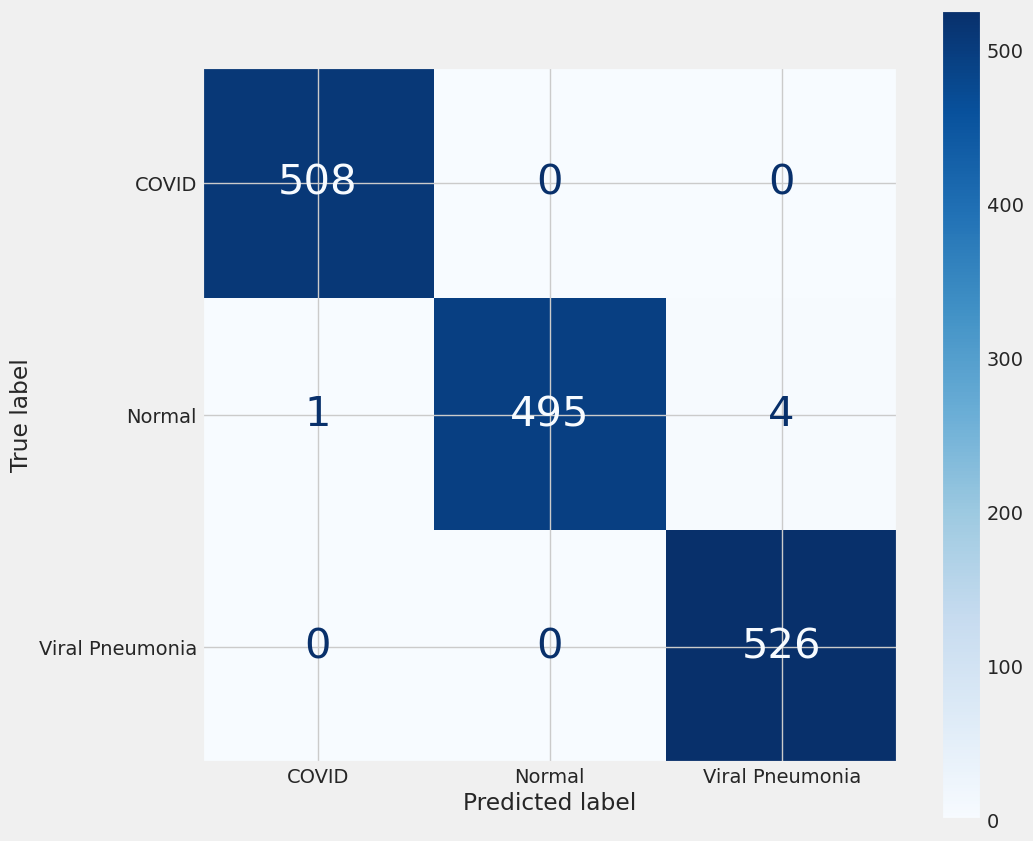

<Axes: >

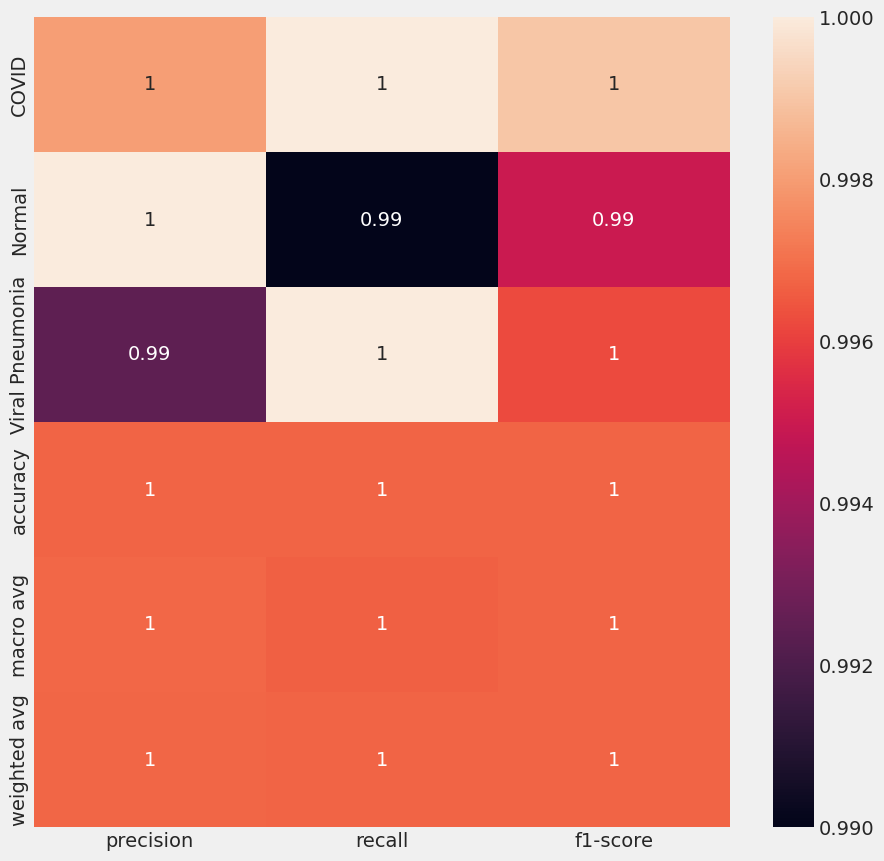

In [46]:
# Plot the evaluation results

class_dict = test_gen.class_indices
new_dict = {}
    
for key,value in class_dict.items():
    new_dict[value] = key             
    
classes = list(new_dict.values()) 

cm = confusion_matrix(testY, avg_ensemble_pred) 
cr = (classification_report(testY, avg_ensemble_pred, target_names = classes, output_dict = True, digits = 4)) 

labels = classes
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = labels)
fig, ax = plt.subplots(figsize = (10,10))
disp.plot(cmap = plt.cm.Blues,ax = ax)

for labels in disp.text_.ravel():
    labels.set_fontsize(30)

plt.show()
fig, ax = plt.subplots(figsize = (10, 10)) 
sns.heatmap(pd.DataFrame(cr).iloc[:-1, :].T, annot = True, ax = ax)